# Team Project #4 - Spatial Estimation
## Dr. Pyrcz's Stochastic Method for Reservoir Modeling
## Team 4: Qiqi Wang, Jiacheng Wang, Yanli pei, Honggeun Jo



## Objectives
### 1. Apply indicator kriging for facies to calculate the propability of each facies across the reservoir
               
### 2. Apply oridnary kriging for porosity and permeability to calculate the kriging estimate and variance (by-facies)

### 3. Build a combined model with porosity and permeability (cookie-cutter approach)

### 4. Report local P10 and P90 map for porosity and permeability at all locations (probability of each facies, CDF)

### 5. Pick 2 candidate well locations and provide a predrill porosity uncertainty distribution (linear family of distribution models)

# 0. Load package, initial setting, and fetching data

In [3]:
## Import needed package
import os                                                   # set current working directory 
import numpy as np                                          # ndarrays
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from scipy import stats                                     # summary stats
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        
import seaborn as sns
import scipy.stats as st                               # statistical methods
import scipy.signal as signal             # kernel for moving window calculation
import random
import math  

## Set Working Directory
os.chdir("C:/Users/jhg13/Documents/GeoStat")  # set the working directory

# Load Data 
df = pd.read_csv("4_sample_data.csv")                       # well sample data
#AI_map = np.loadtxt("4_AI.csv", delimiter = ",")            # AI map

#Log permeability 
df['lnPerm'] = np.log(df['Perm'])
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records

It seems that the first column seems not needed...

# 1. Indicator Kriging for Facies

In [26]:
nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                               # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values

xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell
cmap = plt.cm.plasma  

In [27]:
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [1-0.887,0.887]                         # the global proportions of the categories (from update #2)
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.2,azi1=45,hmaj1=500,hmin1=200,it2=3,cc2=0.8,azi2=45,hmaj2=9999,hmin2=700)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.2,azi1=45,hmaj1=500,hmin1=200,it2=3,cc2=0.8,azi2=45,hmaj2=9999,hmin2=700)) # sand indicator variogram


Data for IK3D: Variable column Facies
  Number   = 178
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


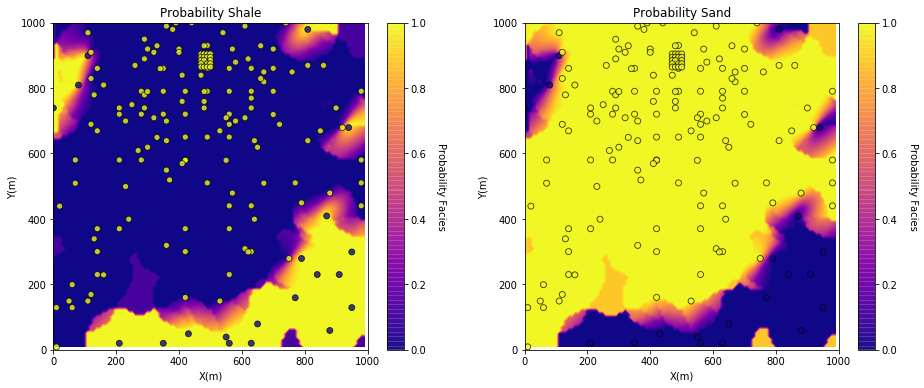

In [28]:

no_trend = np.zeros((1,1))                  # null ndarray not of correct size so ik2d will not use a trend - will fix this
ikmap = geostats.ik2d(df,'X','Y','Facies',ivtype,0,2,thresh,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz, ndmin,ndmax,radius,ktype,vario=varios)

plt.subplot(221) 
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)
plt.subplot(222) 
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2) 
plt.show()

# 2. Ordinary Kriging for Porosity and Permeability (by-facies)


In [29]:
# Decluster for mean poro and perm
wts_sand, cell_sizes_sand, dmeans_sand = geostats.declus(df_sand,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
wts_sand, cell_sizes_sand, dmeans_sand = geostats.declus(df_sand,'X','Y','lnPerm',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
wts_shale, cell_sizes_shale, dmeans_shale = geostats.declus(df_shale,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
wts_shale, cell_sizes_shale, dmeans_shale = geostats.declus(df_shale,'X','Y','lnPerm',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
NULL, cell_sizes_shale, dmeans_shale = geostats.declus(df,'X','Y','Facies',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)

df_sand['Wts'] = wts_sand  
df_shale['Wts'] = wts_shale

There are 158 data with:
   mean of      0.1267502895611484 
   min and max  0.07921048095026448 and 0.1863112059530446
   standard dev 0.034889607535165096 
There are 158 data with:
   mean of      3.26725772203272 
   min and max  -3.603863746878303 and 8.646434493277706
   standard dev 2.112748390526089 
There are 20 data with:
   mean of      0.0888450949811277 
   min and max  0.07860128679786413 and 0.09799110192448944
   standard dev 0.006207447567888193 
There are 20 data with:
   mean of      1.4862494836098044 
   min and max  -1.5500677163308794 and 4.868426341988389
   standard dev 1.8355411328829778 
There are 178 data with:
   mean of      0.8876404494382022 
   min and max  0.0 and 1.0
   standard dev 0.31580829938326277 


In [30]:
skmean_por_sand = 0.13; skmean_por_shale = 0.09
skmean_lnperm_sand = 3.2672; skmean_lnperm_shale = 1.486

skstd_por_sand = 0.034889; skstd_por_shale = 0.00620
skstd_lnperm_sand = 2.1127; skstd_lnperm_shale = 1.8355


ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value

por_sand_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.2,azi1=22.5,hmaj1=200,hmin1=50,it2=3,cc2=0.8,azi2=22.5,hmaj2=600,hmin2=250) # porosity sand variogram
por_shale_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.2,azi1=22.5,hmaj1=100,hmin1=50,it2=3,cc2=0.8,azi2=22.5,hmaj2=900,hmin2=300) # porosity shale variogram

perm_sand_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.4,azi1=45,hmaj1=150,hmin1=100,it2=3,cc2=0.6,azi2=45,hmaj2=900,hmin2=180) # perm sand variogram
perm_shale_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.2,azi1=45,hmaj1=900,hmin1=100,it2=3,cc2=0.8,azi2=45,hmaj2=900,hmin2=180) # perm shale variogram

facies_kmap = np.zeros((ny,nx)); por_kmap = np.zeros((ny,nx)); perm_kmap = np.zeros((ny,nx)) # declare array to combine values

In [31]:
por_sand_kmap, por_sand_vmap = geostats.kb2d(df_sand,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_sand,por_sand_vario)
perm_sand_kmap, perm_sand_vmap = geostats.kb2d(df_sand,'X','Y','lnPerm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_lnperm_sand,perm_sand_vario)
por_shale_kmap, por_shale_vmap = geostats.kb2d(df_shale,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_shale,por_shale_vario)
perm_shale_kmap, perm_shale_vmap = geostats.kb2d(df_shale,'X','Y','lnPerm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_lnperm_shale,perm_shale_vario)


  Estimated   10000 blocks 
      average   0.10277579968937507  variance  0.000543041411667354
  Estimated   10000 blocks 
      average   2.974114212445925  variance  2.314697035955705
  Estimated   10000 blocks 
      average   0.08846982618749352  variance  4.742535892856073e-05
  Estimated   10000 blocks 
      average   2.9260289775547967  variance  2.9568717479533984


C:\Users\jhg13\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


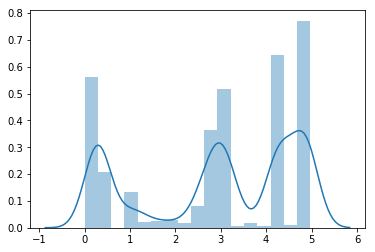

In [32]:
perm_sand_kmap.max()
import seaborn as sns

sns.distplot(perm_shale_kmap.flatten())
plt.show()

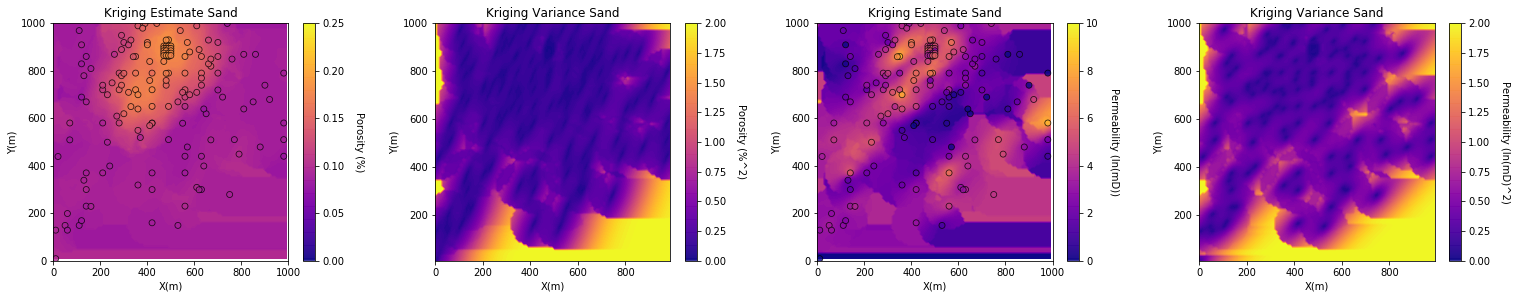

In [117]:
plt.figure(figsize=(10,1.5))
plt.subplot(141)
GSLIB.locpix_st(por_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_sand,'X','Y','Porosity',
                'Kriging Estimate Sand','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(142)
GSLIB.pixelplt_st(por_sand_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,2
                ,'Kriging Variance Sand','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplot(143)
GSLIB.locpix_st(perm_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,10,df_sand,'X','Y','lnPerm',
                'Kriging Estimate Sand','X(m)','Y(m)','Permeability (ln(mD))',cmap)

plt.subplot(144)
GSLIB.pixelplt_st(perm_sand_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,2,
                  'Kriging Variance Sand','X(m)','Y(m)','Permeability (ln(mD)^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

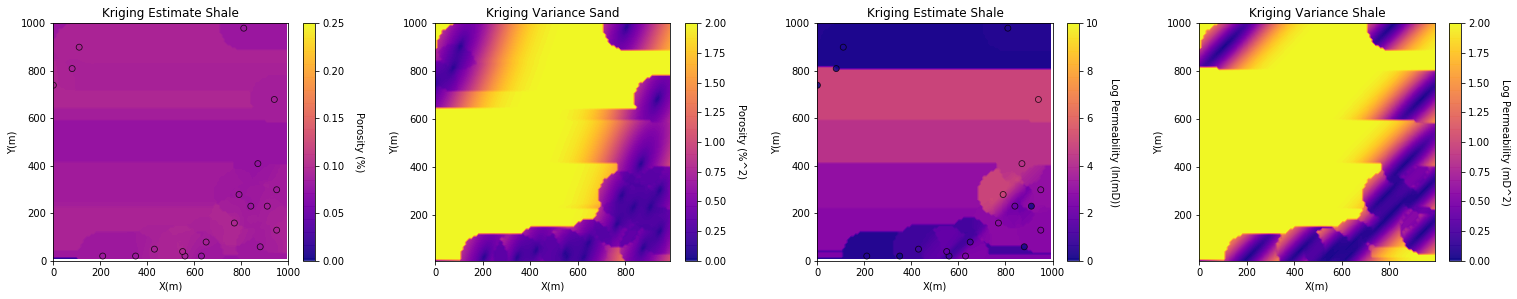

In [119]:
plt.figure(figsize=(10,1.5))
plt.subplot(141)
GSLIB.locpix_st(por_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_shale,'X','Y','Porosity','Kriging Estimate Shale','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(142)
GSLIB.pixelplt_st(por_shale_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,2,'Kriging Variance Sand','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplot(143)
GSLIB.locpix_st(perm_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,10,df_shale,'X','Y','lnPerm','Kriging Estimate Shale','X(m)','Y(m)','Log Permeability (ln(mD))',cmap)

plt.subplot(144)
GSLIB.pixelplt_st(perm_shale_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,2,'Kriging Variance Shale','X(m)','Y(m)','Log Permeability (mD^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

# 3. Combined Model with Porosity and Permeability (cookie-cutter approach)


In [35]:
for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            facies_kmap[iy,ix] = 1
            por_kmap[iy,ix] = por_sand_kmap[iy,ix];
            perm_kmap[iy,ix] = perm_sand_kmap[iy,ix];
            por_shale_kmap[iy,ix] = -1
            perm_shale_kmap[iy,ix] = -1
        else:                      # current location is assumed to be shale
            facies_kmap[iy,ix] = 0
            por_kmap[iy,ix] = por_shale_kmap[iy,ix];
            perm_kmap[iy,ix] = perm_shale_kmap[iy,ix];
            por_sand_kmap[iy,ix] = -1
            perm_sand_kmap[iy,ix] = -1

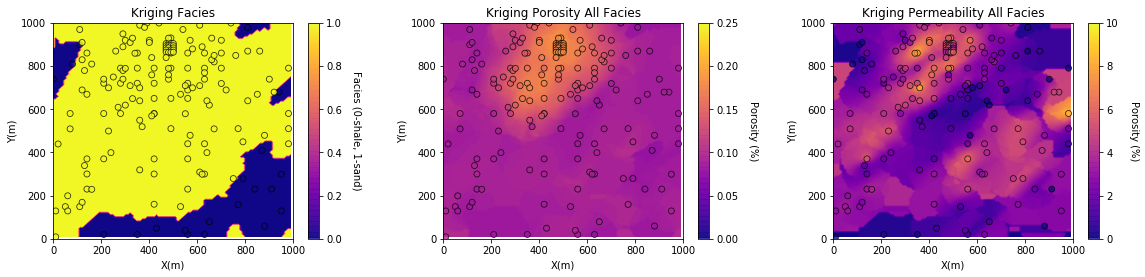

In [36]:
plt.figure(figsize=(5,2.5))
plt.subplot(131)
GSLIB.locpix_st(facies_kmap,xmin,xmax,ymin,ymax,xsiz,0,1,df,'X','Y','Facies','Kriging Facies','X(m)','Y(m)','Facies (0-shale, 1-sand)',cmap)

plt.subplot(132)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Kriging Porosity All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(133)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,10,df,'X','Y','lnPerm','Kriging Permeability All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

# 4. Report Local P10 and P90 Map for Porosity and Permeability 

In [ ]:
from scipy.stats import norm
import math
# f = norm.ppf(0.9)
# print(f)

skmean_por_sand = 0.13; skmean_por_shale = 0.09
skmean_perm_sand = 180.2; skmean_perm_shale = 21.4
skstd_por_sand = 0.034889; skstd_por_shale = 0.00620
skstd_lnperm_sand = 2.1127; skstd_lnperm_shale = 1.8355

map_p10_poro = np.zeros((100,100))
map_p90_poro = np.zeros((100,100))
map_p10_lnperm = np.zeros((100,100))
map_p90_lnperm = np.zeros((100,100))


for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            map_p10_poro[iy,ix] = norm.ppf(.1) * math.sqrt(por_sand_vmap[iy,ix]) * skstd_por_sand + por_sand_kmap[iy,ix]
            map_p90_poro[iy,ix] = norm.ppf(.9) * math.sqrt(por_sand_vmap[iy,ix]) * skstd_por_sand + por_sand_kmap[iy,ix]
            
            map_p10_lnperm[iy,ix] = norm.ppf(.1) * math.sqrt(perm_sand_vmap[iy,ix]) * skstd_lnperm_sand + perm_sand_kmap[iy,ix]
            map_p90_lnperm[iy,ix] = norm.ppf(.9) * math.sqrt(perm_sand_vmap[iy,ix]) * skstd_lnperm_sand + perm_sand_kmap[iy,ix]
        else:                      # current location is assumed to be shale
            map_p10_poro[iy,ix] = norm.ppf(.1) * math.sqrt(por_shale_vmap[iy,ix]) * skstd_por_shale + por_shale_kmap[iy,ix]
            map_p90_poro[iy,ix] = norm.ppf(.9) * math.sqrt(por_shale_vmap[iy,ix]) * skstd_por_shale + por_shale_kmap[iy,ix]
            
            map_p10_lnperm[iy,ix] = norm.ppf(.1) * math.sqrt(perm_shale_vmap[iy,ix]) * skstd_lnperm_shale + perm_shale_kmap[iy,ix]
            map_p90_lnperm[iy,ix] = norm.ppf(.9) * math.sqrt(perm_shale_vmap[iy,ix]) * skstd_lnperm_shale + perm_shale_kmap[iy,ix]

In [57]:
print(map_p10_poro.flatten().mean())
print(map_p90_poro.flatten().mean())
print(np.exp(map_p10_lnperm.flatten()).mean())
print(np.exp(map_p90_lnperm.flatten()).mean())

0.08323969930060038
0.12106148786218739
13.642899802249044
349.5589484039255


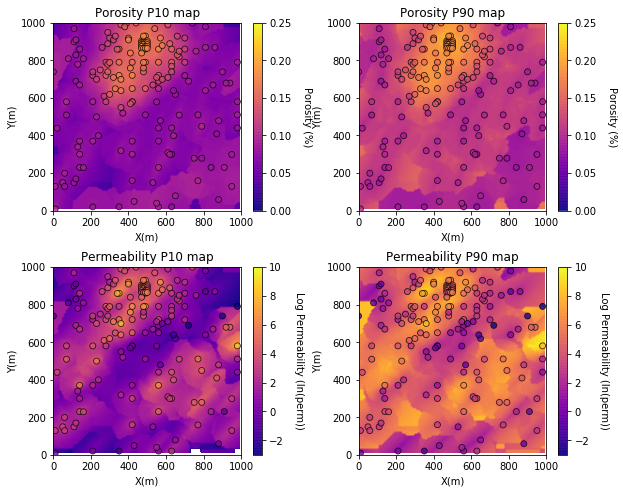

In [38]:
plt.figure(figsize=(2.5,5))
plt.subplot(221)
GSLIB.locpix_st(map_p10_poro,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity',
                'Porosity P10 map','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.locpix_st(map_p90_poro,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity',
                'Porosity P90 map','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(223)
GSLIB.locpix_st(map_p10_lnperm,xmin,xmax,ymin,ymax,xsiz,-3,10,df,'X','Y','lnPerm',
                'Permeability P10 map','X(m)','Y(m)','Log Permeability (ln(perm))',cmap)

plt.subplot(224)
GSLIB.locpix_st(map_p90_lnperm,xmin,xmax,ymin,ymax,xsiz,-3,10,df,'X','Y','lnPerm',
                'Permeability P90 map','X(m)','Y(m)','Log Permeability (ln(perm))',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

# 5. Pick 2 Candidate Well Locations, Provide a Predrill Porosity Uncertainty Distribution (linear family of distribution models) 

In [39]:
por_sand_kmap, por_sand_vmap = geostats.kb2d(df_sand,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_sand,por_sand_vario)
perm_sand_kmap, perm_sand_vmap = geostats.kb2d(df_sand,'X','Y','lnPerm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_lnperm_sand,perm_sand_vario)
por_shale_kmap, por_shale_vmap = geostats.kb2d(df_shale,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_shale,por_shale_vario)
perm_shale_kmap, perm_shale_vmap = geostats.kb2d(df_shale,'X','Y','lnPerm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_lnperm_shale,perm_shale_vario)

  Estimated   10000 blocks 
      average   0.10277579968937507  variance  0.000543041411667354
  Estimated   10000 blocks 
      average   2.974114212445925  variance  2.314697035955705
  Estimated   10000 blocks 
      average   0.08846982618749352  variance  4.742535892856073e-05
  Estimated   10000 blocks 
      average   2.9260289775547967  variance  2.9568717479533984


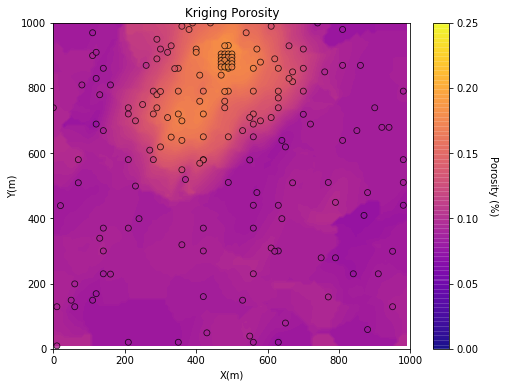

In [40]:
plt.figure(figsize=(8,6))
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Kriging Porosity','X(m)','Y(m)','Porosity (%)',cmap)
plt.show()

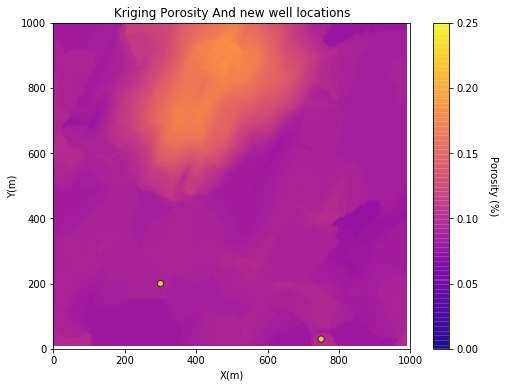

In [41]:
import pandas as pd 
data = [['Well_1', 300, 200, 100], ['Well_1', 750, 30, 100]]
df_well_location = pd.DataFrame(data, columns = ['Name', 'X', 'Y', 'Null']) 

plt.figure(figsize=(8,6))
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_well_location,'X','Y','Null','Kriging Porosity And new well locations','X(m)','Y(m)','Porosity (%)',cmap)
plt.show()

In [42]:
# well location is map
X1 = 29; Y1 = 79
X2 = 74; Y2 = 96

In [43]:
prabaility_bins = np.array(range(1,100,1))/100
CDF_porosity_well_1 = np.zeros(prabaility_bins.size)
CDF_logperm_well_1  = np.zeros(prabaility_bins.size)
CDF_porosity_well_2 = np.zeros(prabaility_bins.size)
CDF_logperm_well_2  = np.zeros(prabaility_bins.size)

In [44]:
CDF_porosity_well_1 = np.zeros(prabaility_bins.size)
CDF_porosity_well_1.shape

(99,)

In [104]:
prob_shale_well_1 = ikmap[Y1,X1,0]; prob_sand_well_1 = 1 - prob_shale_well_1
prob_shale_well_2 = ikmap[Y2,X2,0]; prob_sand_well_2 = 1 - prob_shale_well_2

por_sand_vmap_1 = por_sand_vmap[Y1,X1]
por_sand_vmap_2 = por_sand_vmap[Y2,X2]
por_shale_vmap_1 = por_shale_vmap[Y1,X1]
por_shale_vmap_2 = por_shale_vmap[Y2,X2]
perm_sand_vmap_1 = perm_sand_vmap[Y1,X1]
perm_sand_vmap_2 = perm_sand_vmap[Y2,X2]
perm_shale_vmap_1 = perm_shale_vmap[Y1,X1]
perm_shale_vmap_2 = perm_shale_vmap[Y2,X2]

por_sand_kmap_1 = por_sand_kmap[Y1,X1]
por_sand_kmap_2 = por_sand_kmap[Y2,X2]
por_shale_kmap_1 = por_shale_kmap[Y1,X1]
por_shale_kmap_2 = por_shale_kmap[Y2,X2]
perm_sand_kmap_1 = perm_sand_kmap[Y1,X1]
perm_sand_kmap_2 = perm_sand_kmap[Y2,X2]
perm_shale_kmap_1 = perm_shale_kmap[Y1,X1]
perm_shale_kmap_2 = perm_shale_kmap[Y2,X2]
print(np.exp(perm_sand_kmap_1))
print(np.exp(perm_shale_kmap_1))
math.sqrt(perm_shale_vmap_1) * skstd_lnperm_sand
# norm.ppf(prabaility_bins)
prob_shale_well_1 + prob_sand_well_1
# ip = 98
prob_shale_well_1 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(por_shale_vmap_1) * skstd_por_shale + por_shale_kmap_1)   
# prob_sand_well_1 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(por_sand_vmap_1) * skstd_por_sand  + por_sand_kmap_1)
norm.ppf(prabaility_bins[ip]) * math.sqrt(por_shale_vmap_1) * skstd_por_shale + por_shale_kmap_1
norm.ppf(prabaility_bins[ip]) * math.sqrt(por_sand_vmap_1) * skstd_por_sand  + por_sand_kmap_1

prob_sand_well_1 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(perm_sand_vmap_1) * skstd_lnperm_sand  + perm_sand_kmap_1)
prob_shale_well_1 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(perm_shale_vmap_1) * skstd_lnperm_sand  + perm_shale_kmap_1)
ip
CDF_logperm_well_2

48.71720859349961
15.787066717776801


array([-2.903695  , -2.21088617, -1.77132117, -1.44065355, -1.17168095,
       -0.94274302, -0.74200925, -0.56227609, -0.39881598, -0.24835067,
       -0.10850887,  0.02248314,  0.14598876,  0.26307997,  0.37461588,
        0.48129641,  0.58369992,  0.68231034,  0.77753708,  0.86972996,
        0.95919054,  1.0461809 ,  1.13093051,  1.21364165,  1.29449374,
        1.37364693,  1.4512449 ,  1.52741727,  1.60228154,  1.67594475,
        1.74850485,  1.82005186,  1.8906689 ,  1.96043302,  2.02941596,
        2.09768476,  2.16530236,  2.23232808,  2.29881804,  2.36482557,
        2.43040154,  2.49559468,  2.56045189,  2.62501843,  2.68933825,
        2.75345413,  2.81740794,  2.88124083,  2.9449934 ,  3.0087059 ,
        3.0724184 ,  3.13617097,  3.20000386,  3.26395767,  3.32807355,
        3.39239337,  3.45695991,  3.52181711,  3.58701026,  3.65258623,
        3.71859376,  3.78508372,  3.85210943,  3.91972704,  3.98799584,
        4.05697877,  4.1267429 ,  4.19735994,  4.26890695,  4.34

In [102]:
ip = 98
prob_shale_well_1 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(perm_shale_vmap_1) * skstd_lnperm_sand  + perm_shale_kmap_1)
+ prob_sand_well_1 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(perm_sand_vmap_1) * skstd_lnperm_sand  + perm_sand_kmap_1)
CDF_logperm_well_1
prabaility_bins[ip]

0.99

In [105]:
for ip in range(0,99):
    CDF_porosity_well_1[(ip)]= prob_shale_well_1 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(por_shale_vmap_1) * skstd_por_shale + por_shale_kmap_1)    + prob_sand_well_1 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(por_sand_vmap_1) * skstd_por_sand  + por_sand_kmap_1)
    CDF_logperm_well_1[(ip)]= prob_shale_well_1 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(perm_shale_vmap_1) * skstd_lnperm_sand  + perm_shale_kmap_1)    + prob_sand_well_1 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(perm_sand_vmap_1) * skstd_lnperm_sand  + perm_sand_kmap_1)
    
    CDF_porosity_well_2[(ip)]= prob_shale_well_2 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(por_shale_vmap_2) * skstd_por_shale + por_shale_kmap_2)    + prob_sand_well_2 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(por_sand_vmap_2) * skstd_por_sand + por_sand_kmap_2)
    CDF_logperm_well_2[(ip)]= prob_shale_well_2 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(perm_shale_vmap_2) * skstd_lnperm_shale + perm_shale_kmap_2)    + prob_sand_well_2 * (norm.ppf(prabaility_bins[ip]) * math.sqrt(perm_sand_vmap_2) * skstd_lnperm_shale + perm_sand_kmap_2)    

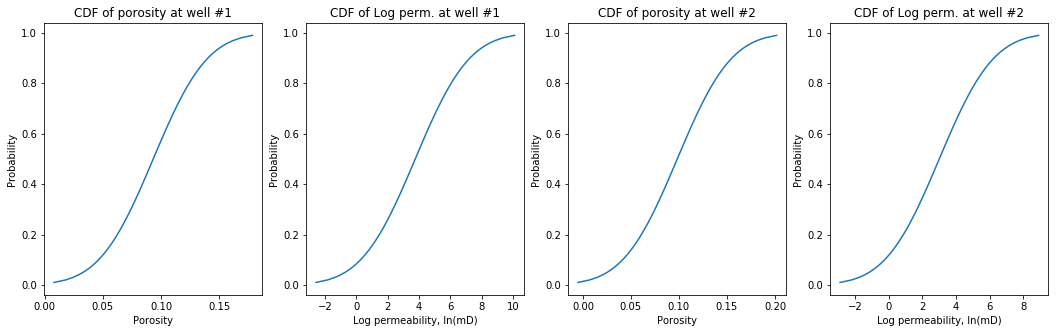

In [112]:
plt.figure(figsize=(18,5))

plt.subplot(141)
plt.plot(CDF_porosity_well_1,prabaility_bins)
plt.xlabel('Porosity'); plt.ylabel('Probability'); plt.title('CDF of porosity at well #1')
plt.subplot(142)
plt.plot(CDF_logperm_well_1,prabaility_bins)
plt.xlabel('Log permeability, ln(mD)'); plt.ylabel('Probability'); plt.title('CDF of Log perm. at well #1')
plt.subplot(143)
plt.plot(CDF_porosity_well_2,prabaility_bins)
plt.xlabel('Porosity'); plt.ylabel('Probability'); plt.title('CDF of porosity at well #2')
plt.subplot(144)
plt.plot(CDF_logperm_well_2,prabaility_bins)
plt.xlabel('Log permeability, ln(mD)'); plt.ylabel('Probability'); plt.title('CDF of Log perm. at well #2')
plt.show()

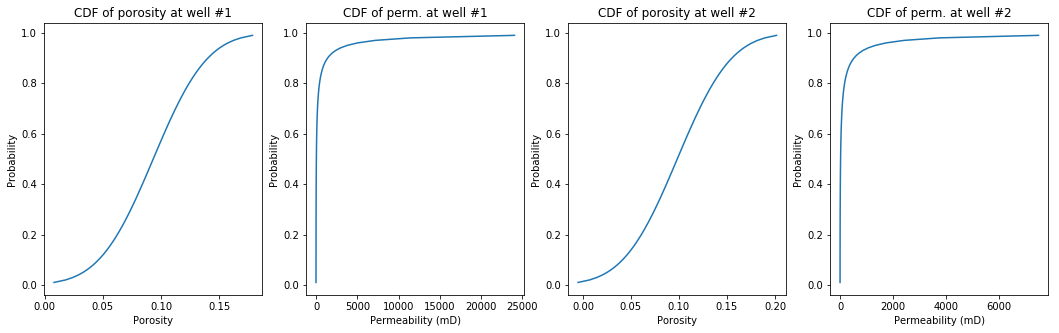

In [111]:
plt.figure(figsize=(18,5))

plt.subplot(141)
plt.plot(CDF_porosity_well_1,prabaility_bins)
plt.xlabel('Porosity'); plt.ylabel('Probability'); plt.title('CDF of porosity at well #1')
plt.subplot(142)
plt.plot(np.exp(CDF_logperm_well_1),prabaility_bins)
plt.xlabel('Permeability (mD)'); plt.ylabel('Probability'); plt.title('CDF of perm. at well #1')
plt.subplot(143)
plt.plot(CDF_porosity_well_2,prabaility_bins)
plt.xlabel('Porosity'); plt.ylabel('Probability'); plt.title('CDF of porosity at well #2')
plt.subplot(144)
plt.plot(np.exp(CDF_logperm_well_2),prabaility_bins)
plt.xlabel('Permeability (mD)'); plt.ylabel('Probability'); plt.title('CDF of perm. at well #2')
plt.show()

C:\Users\jhg13\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


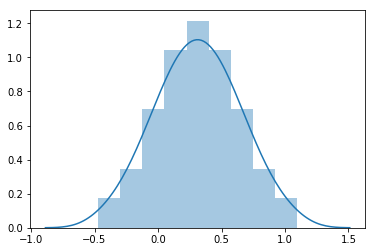

In [65]:
sns.distplot((CDF_logperm_well_1))